# How to use this notebook

All the data required for this tutorial is readily available in our public repository. To access this valuable resource, we kindly ask users to clone the repository or download its contents by visiting the following link: [Betteromics Examples Repository](https://github.com/betteromics/betteromics-examples/archive/refs/heads/main.zip) and following the instructions in the README. By doing so, you will gain seamless access to all the necessary datasets and materials, ensuring a smooth and enriching experience as you delve into our tutorials and explore the diverse world of Betteromics.


In the notebook cell below, replace `~/betteromics-examples/` with the full path to the directory where you have downloaded the repository. This adjustment will ensure that the script correctly accesses the required data and resources from your local setup.

In [1]:
setwd("~/betteromics-examples/")

When a user runs the cell below, it will check for the required libraries and automatically install any missing ones for this tutorial.

In [2]:
invisible({
# Read the package names from the requirements.txt file
packages <- readLines('R/examples/tcga/requirements_R.txt')

# Filter the packages that are not yet installed
packages_to_install <- setdiff(packages, rownames(installed.packages()))
    
# Install the packages
install.packages(packages_to_install,
                 repos = c("http://irkernel.github.io/", getOption("repos")),
                 type = "source",
                 dependencies = TRUE)
})

In [3]:
library(httr)
library(jsonlite)
library(readr)
library(repr)

options(warn=-1)

# Betteromics API access

In order to connect with Betteromics environment, we need to import the 'util' file below. You can find this in this repo, under `R/util.R`.

This utill file serves as the essential bridge that connects us to the Betteromics API, enabling us to access the wealth of public data and relevant tables it offers. This file contains all the necessary functions and configurations to ensure a smooth and efficient link-up with Betteromics, making it super easy for us to fetch the data we need for our projects. By including this file in our project, we ensure that we can efficiently retrieve, process, and analyze the data from Betteromics, unlocking valuable insights and empowering our work with the comprehensive resources it provides. 

Please ensure you log in to the [Betteromics Public Demo Page](https://public-demo.betteromics.com/) and then proceed to follow the instructions provided in the cell below to gain access to the data.

In [ ]:
source("R/utils.R");

# Access data using SQL

SQL, which stands for Structured Query Language, is a powerful and standardized programming language used for managing and manipulating relational databases. SQL allows users to interact with databases and retrieve data. At Betteromics, SQL serves as a pivotal tool that empowers users to seamlessly access the data they need. We've already taken the initiative to ingest the publicly available TCGA (The Cancer Genome Atlas) data, making it readily accessible to our users. One way to explore this valuable dataset is by querying the `tcga_pancreatic_cancer_analysis_clinical_with_filenames_latest` table. This table contains a wealth of data related to pancreatic cancer analysis, granting users the ability to perform data-driven research and extract meaningful insights for their work in the field of cancer genomics.

In [5]:
query = " 
WITH clinical as (
    SELECT 
        case_submitter_id
      , gender
      , days_to_death
      , vital_status
      , race 
      , alcohol_history 
      , pack_years_smoked
      , cancer_type 
      , tissue_or_organ_of_origin   
      , ajcc_clinical_stage
      , ajcc_pathologic_stage
      , abbreviated_cancer_type
      , age_at_diagnosis AS age_at_diagnosis_days
      , CAST (age_at_diagnosis AS INT) / 365 AS age_at_diagnosis_years
    
    FROM tcga_pancreatic_cancer_analysis_clinical_with_filenames_latest  
    WHERE abbreviated_cancer_type = 'Pancreatic'
  )
  
SELECT * FROM clinical
"

In [6]:
pc <- create_dataframe_from_query(query); #pc stands for Pancreatic Cancer
head(pc)

case_submitter_id,gender,days_to_death,vital_status,race,alcohol_history,pack_years_smoked,cancer_type,tissue_or_organ_of_origin,ajcc_clinical_stage,ajcc_pathologic_stage,abbreviated_cancer_type,age_at_diagnosis_days,age_at_diagnosis_years
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
TCGA-IB-7897,Female,486,Dead,White,Yes,0.00,Pancreatic adenocarcinoma,"Pancreas, NOS",Not Reported,IIB,Pancreatic,19718,54
TCGA-HZ-8315,Female,299,Dead,White,Not reported,0.00,Pancreatic adenocarcinoma,Head of pancreas,Not Reported,IIA,Pancreatic,19839,54
TCGA-HZ-8636,Female,545,Dead,White,No,0.00,Pancreatic adenocarcinoma,Tail of pancreas,Not Reported,IV,Pancreatic,21501,58
TCGA-IB-7888,Female,1332,Dead,Black or African American,No,0.00,Pancreatic adenocarcinoma,"Pancreas, NOS",Not Reported,IIA,Pancreatic,24117,66
TCGA-IB-7893,Male,117,Dead,White,Yes,0.00,Pancreatic adenocarcinoma,"Pancreas, NOS",Not Reported,IIA,Pancreatic,23703,64
TCGA-US-A774,Female,695,Dead,White,Yes,4.65,Pancreatic adenocarcinoma,Head of pancreas,Not Reported,IIB,Pancreatic,27957,76


## Data Wrangling and Data Exploration
Let's take a quick dive into this data to gain a better understanding of pancreatic cancer mortality.

In [7]:
vital_status_counts <- table(pc$vital_status, useNA = "always")
print(vital_status_counts)


Alive  Dead  <NA> 
   83    89     0 


In [8]:
# Create a new column 'is_dead' and map 'vital_status' values to binary
pc$is_dead <- ifelse(pc$vital_status == "Dead", 1, 0)

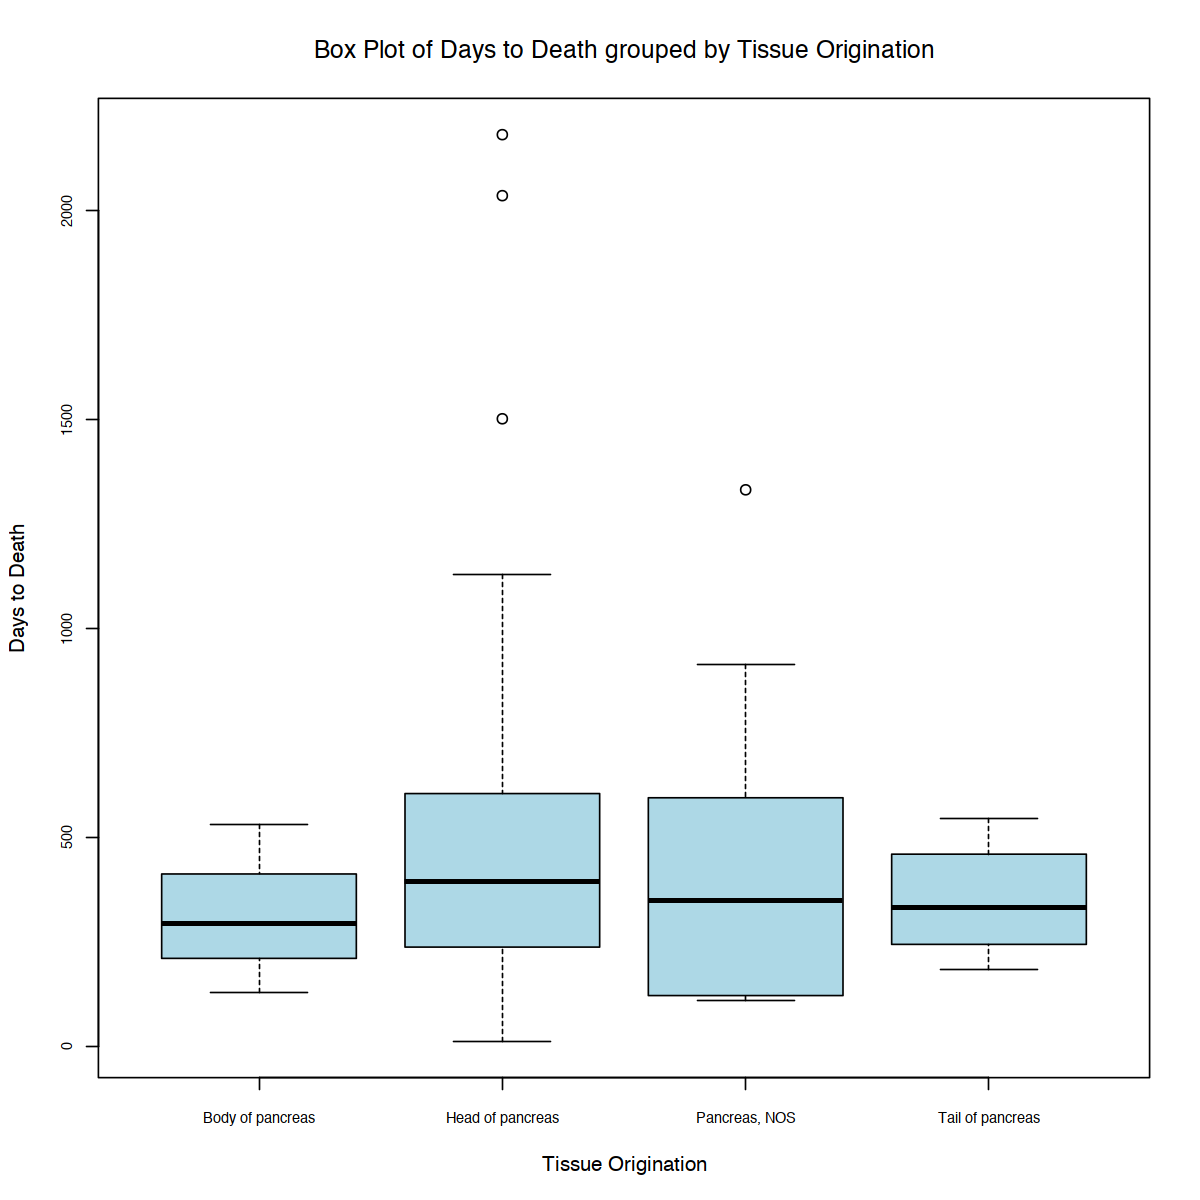

In [9]:
# Create a box plot
options(repr.plot.width=10, repr.plot.height=10)
boxplot(pc$days_to_death ~ pc$tissue_or_organ_of_origin,
        xlab = "Tissue Origination",
        ylab = "Days to Death",
        main = "Box Plot of Days to Death grouped by Tissue Origination",
        col = "lightblue",
        cex.axis = 0.7,
)


# Survival Analysis
A **Kaplan-Meier** plot, often referred to as a survival curve, is a graphical representation used in survival analysis to visualize the probability of an event, typically the survival of a group of individuals, over time. It is especially valuable when studying time-to-event data, such as time to disease recurrence, patient survival, or any event of interest in various fields like medicine, epidemiology, and engineering. The Kaplan-Meier plot provides insights into the probability of an event occurring at different time points while accounting for censored data, where events have not yet occurred or are lost to follow-up. This visualization allows researchers and data analysts to compare the survival experiences of different groups or cohorts, assess the impact of variables or treatments on survival rates, and make informed decisions in areas such as healthcare planning, clinical trials, and risk assessment.

Kindly be aware that this dataset does not contain right-censored data, and conducting a comprehensive survival analysis is beyond the intended scope of this notebook.

In [10]:
# Let's say people who stayed alive follow the current life expectancy for U.S. in 2023 which is ~79 years

DAYS_IN_YEAR <- 365
life_expectancy <- 79.11  # Data source: https://population.un.org/wpp/

life_expectancy_in_days <- life_expectancy* DAYS_IN_YEAR
TIME_CUTOFF <- DAYS_IN_YEAR

In [11]:

maximum_days_before_death_from_data <- max(pc$days_to_death, na.rm = TRUE)
replacement_value <- life_expectancy_in_days - pc$age_at_diagnosis_days

# Replace missing values in 'days_to_death' column with the calculated value
pc$days_to_death <- ifelse(is.na(pc$days_to_death), 
                                    replacement_value, 
                                    pc$days_to_death)


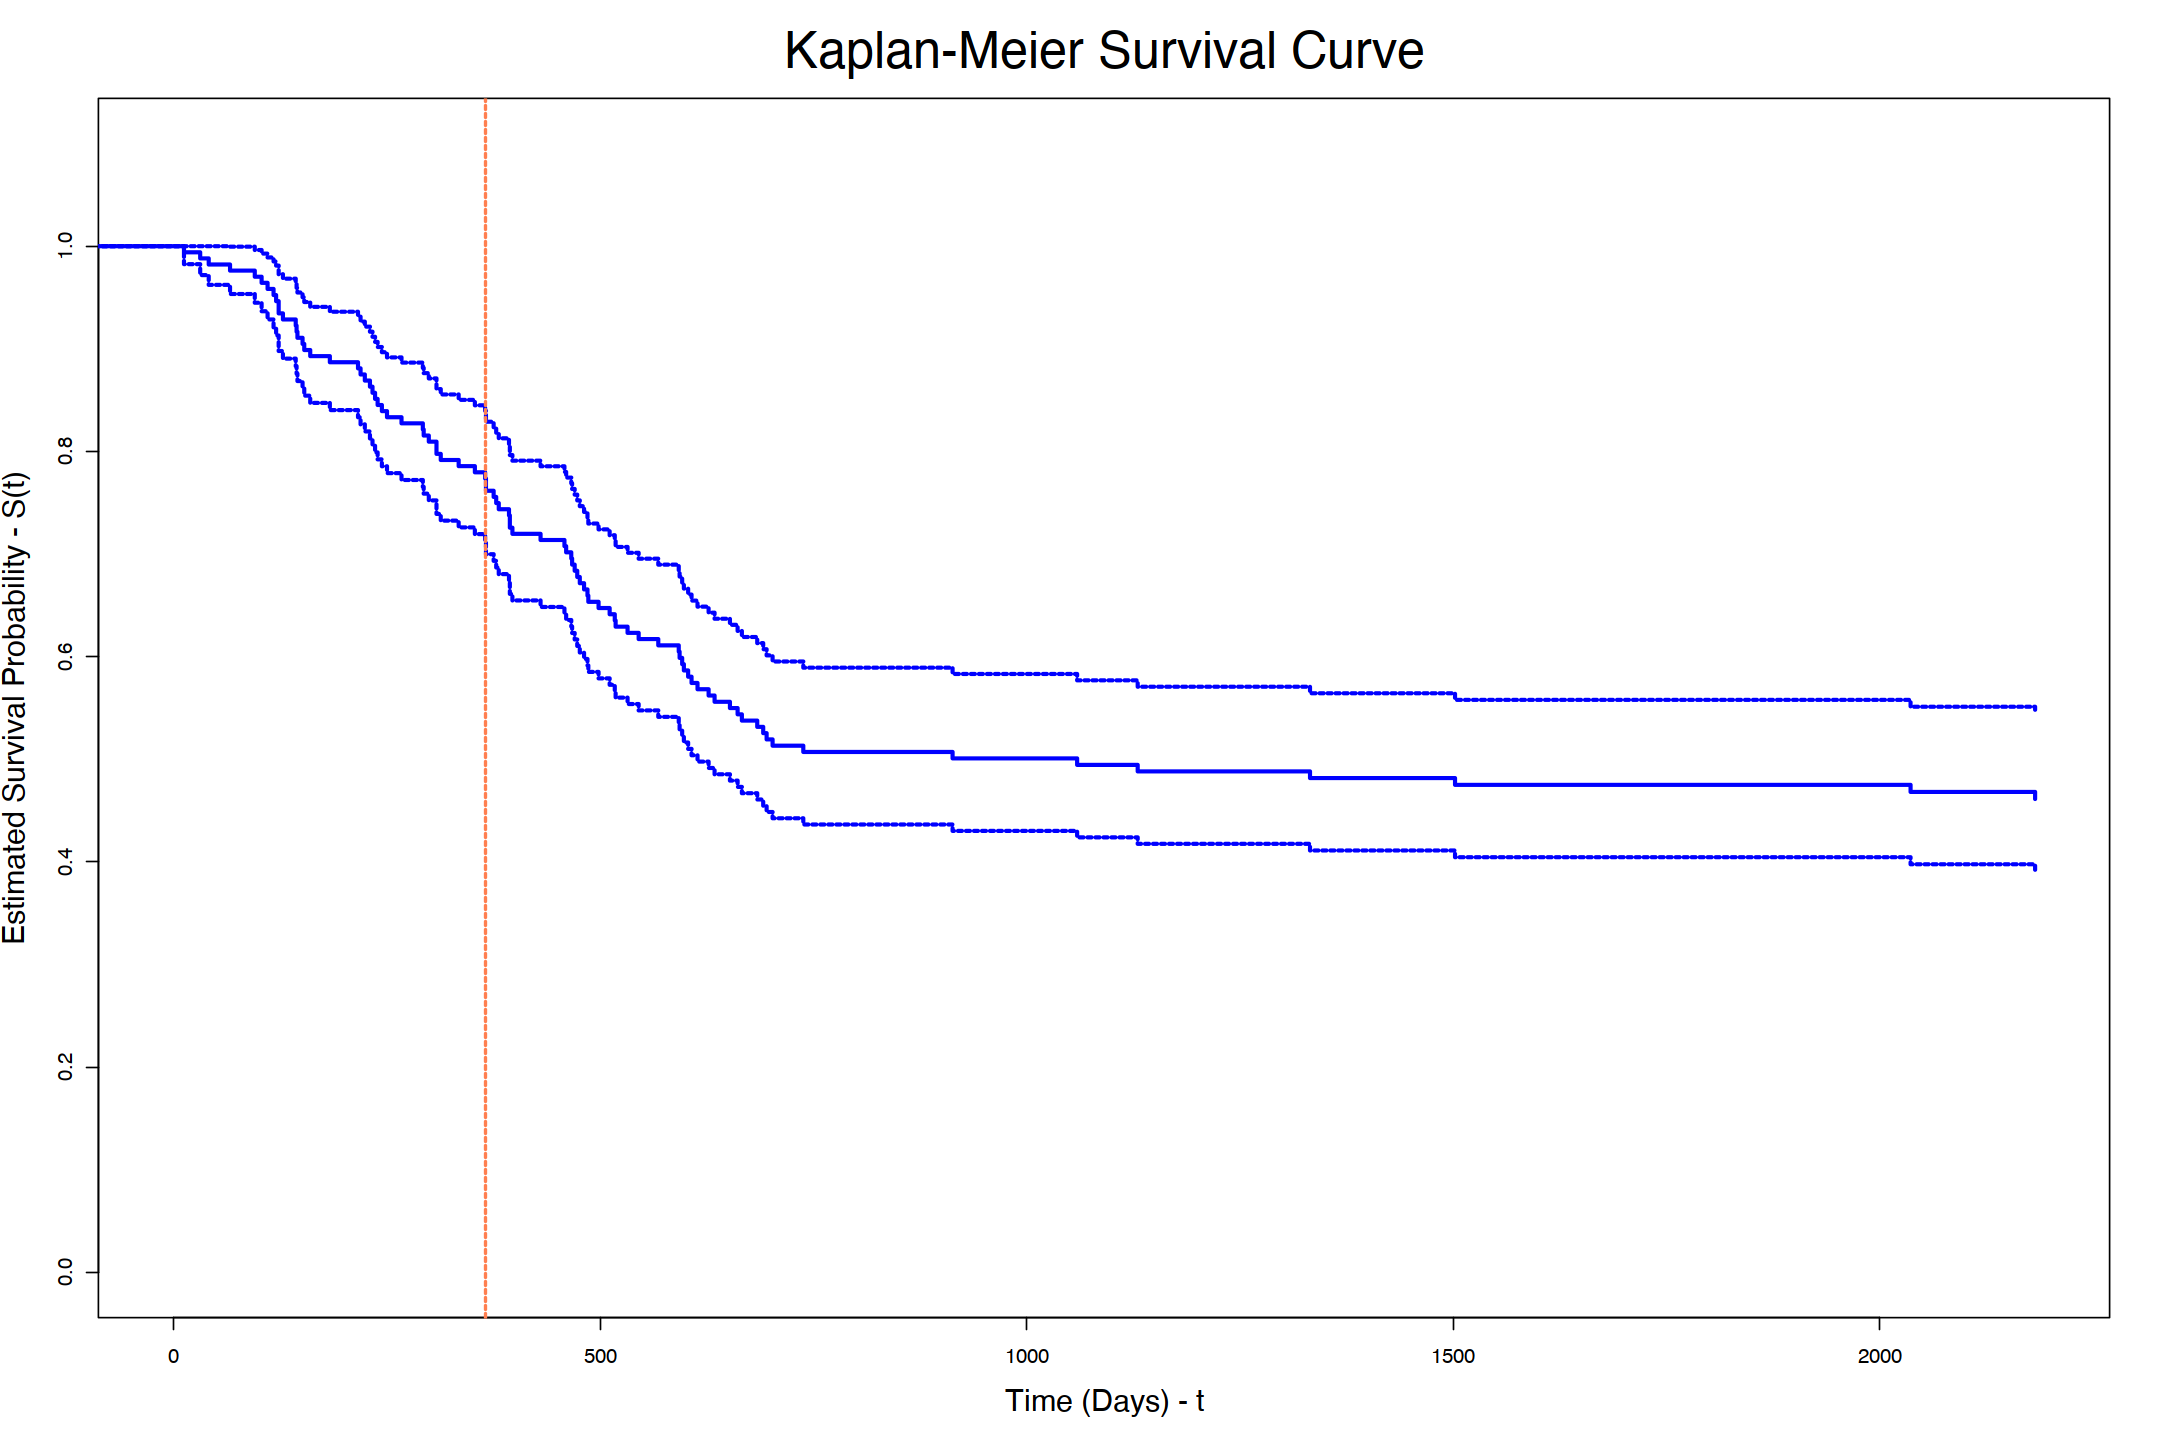

In [12]:
library(survival)

# Create a survival object
survival_obj <- with(pc, Surv(days_to_death, is_dead))

# Fit a Kaplan-Meier survival curve
km_fit <- survfit(survival_obj ~ 0)

# Plot the Kaplan-Meier survival curve
options(repr.plot.width=18, repr.plot.height=12)

plot(km_fit,
     xlim = c(-1, maximum_days_before_death_from_data), 
     ylim = c(0,1.1),
     main = 'Kaplan-Meier Survival Curve', 
     xlab = 'Time (Days) - t', 
     ylab = 'Estimated Survival Probability - S(t)', 
     col = "blue",
     cex.lab=1.5, 
     cex.main=2.5,
     lwd = 2.5
    )

# Add vertical line at TIME_CUTOFF
abline(v = TIME_CUTOFF, lwd = 2, lty = 2, col = "coral")



## Including some of the covariates

In [13]:
# Create a new binary variable 'had_alcohol_history'
pc$had_alcohol_history <- ifelse(
  pc$alcohol_history %in% c("Yes", "Not reported"), 1, 0
)


## Hazard ratio

The hazard ratio represents the ratio of the hazard (risk of an event) for the group with the covariate value of 1 compared to the group with the reference covariate value (usually 0).

Here's what it means:

Hazard Ratio (HR) Interpretation:

| Magnitude of Effect | Hazard Ratio (HR) | Interpretation                       |
|:---------------------|:-------------------|:-------------------------------------|
| No effect           | HR = 1            | No effect                            |
| Increased hazard    | HR > 1            | An HR greater than 1 suggests an increased hazard or risk of the event (e.g., death) for individuals with an alcohol history compared to non-alcohol-users. |
| Reduced hazard      | HR < 1            | An HR less than 1 would indicate a reduced hazard or a protective effect.


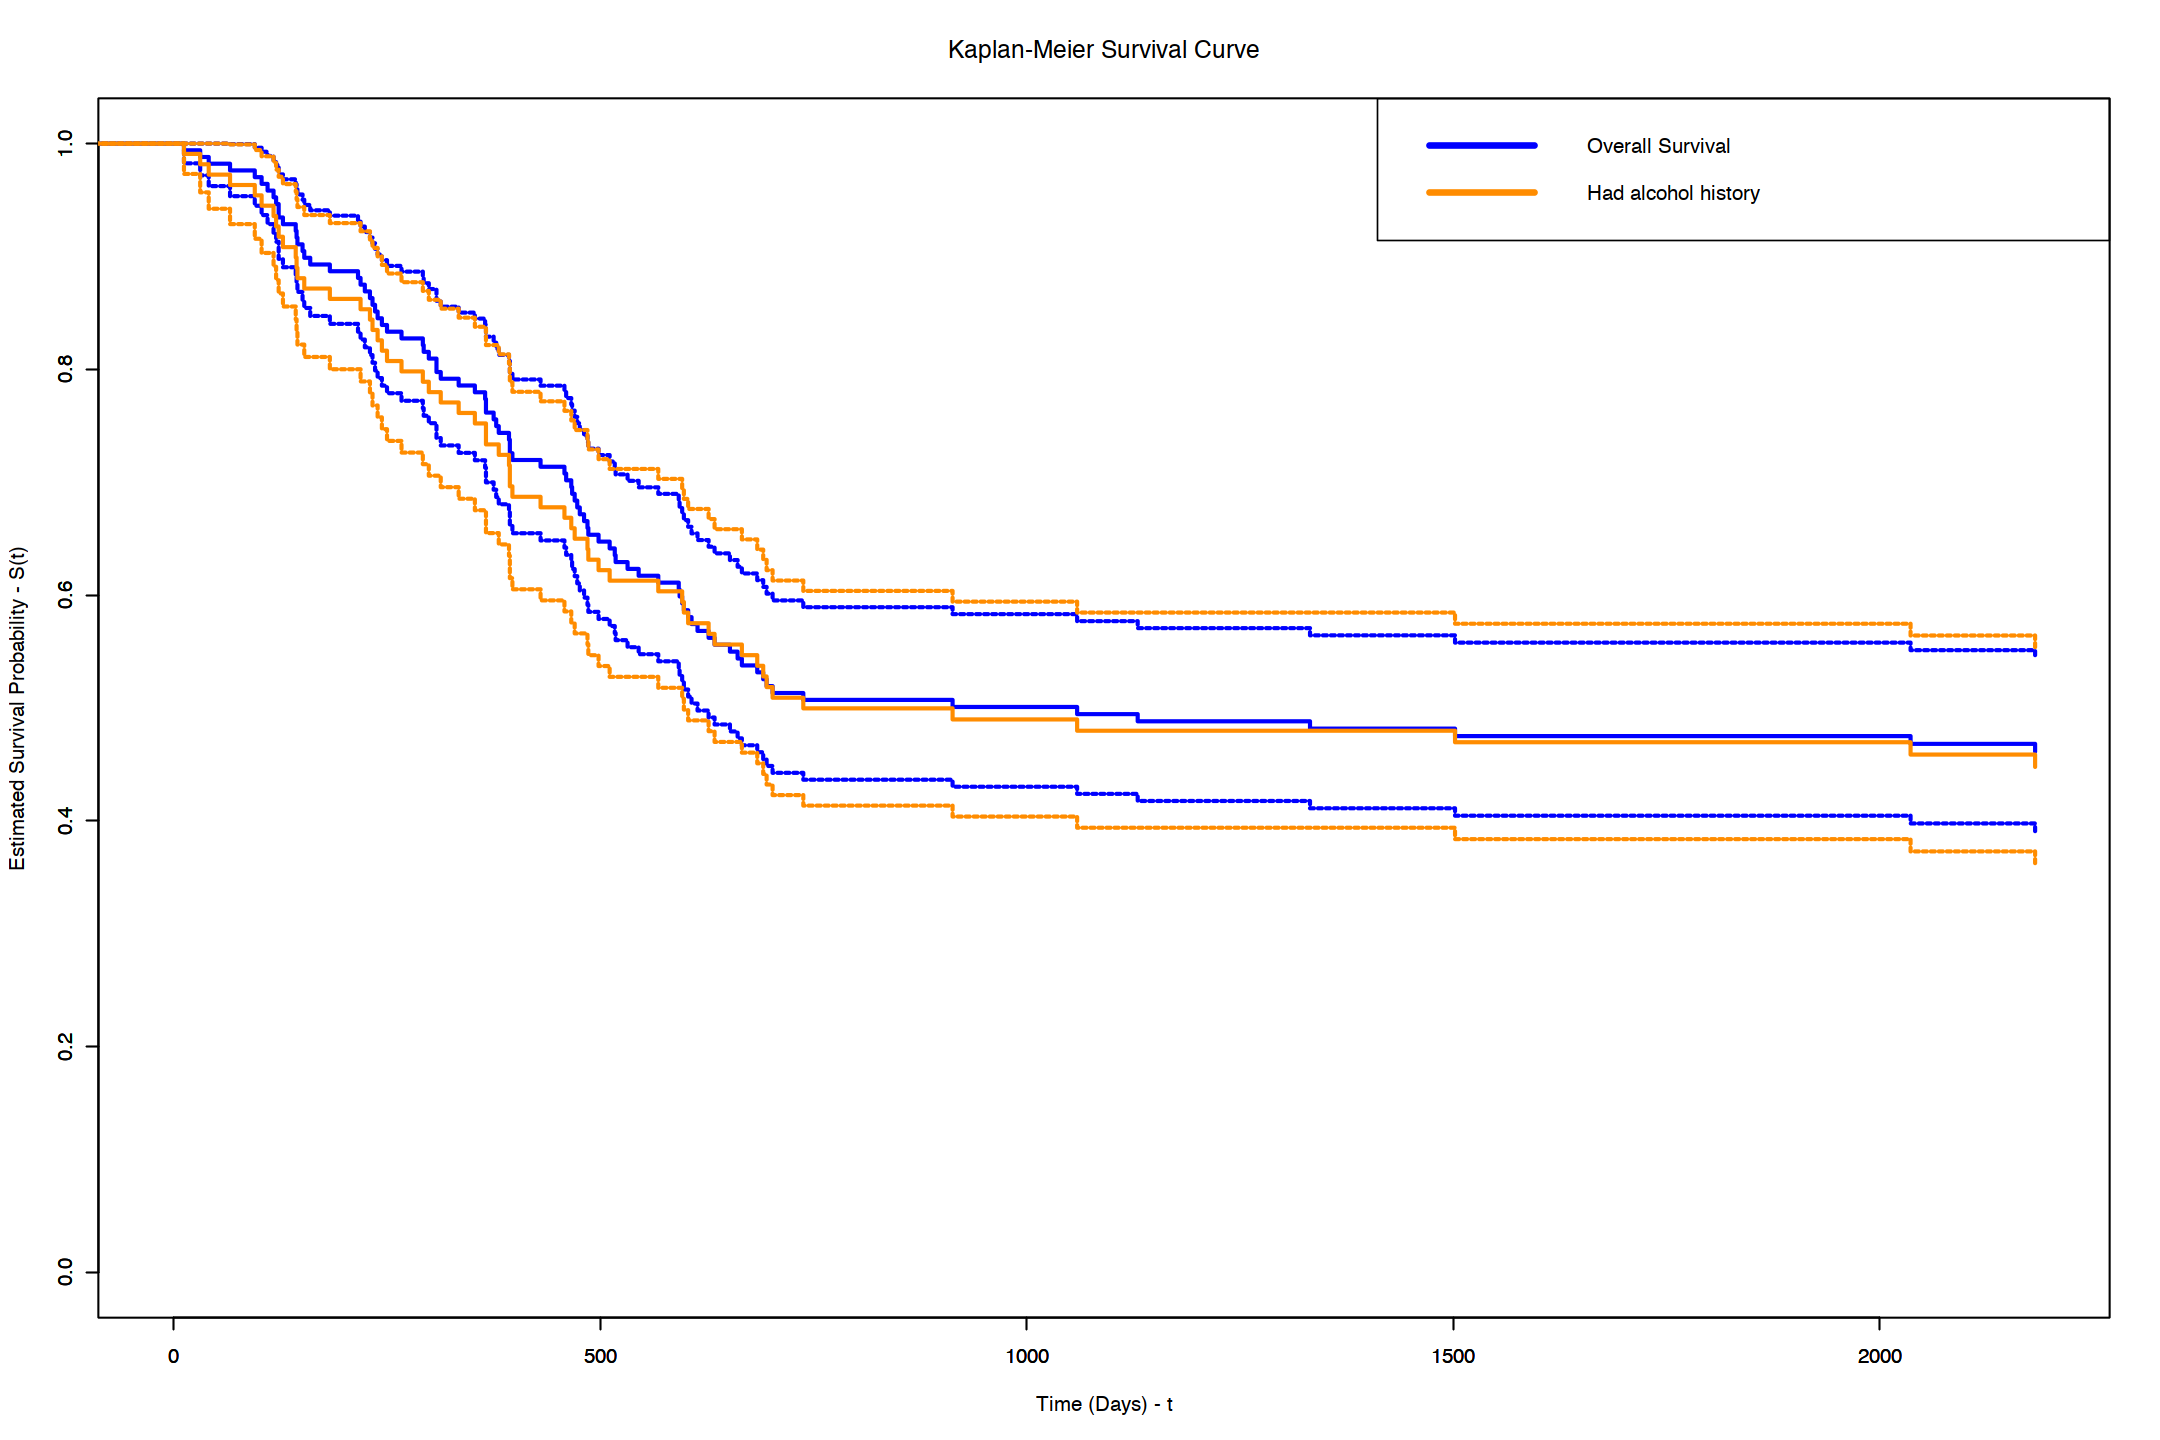

In [14]:
# Create a survival object
survival_obj <- with(pc, Surv(days_to_death, is_dead))

# Fit a Kaplan-Meier survival curve
km_fit <- survfit(survival_obj ~ 1)


# Plot the Kaplan-Meier survival curve
options(repr.plot.width=18, repr.plot.height=12)
plot(km_fit,
     xlim = c(-1, maximum_days_before_death_from_data), 
     main = 'Kaplan-Meier Survival Curve', 
     xlab = 'Time (Days) - t', 
     ylab = 'Estimated Survival Probability - S(t)', 
     col = "blue",
     lwd = 2.5,
    )

par(new=TRUE)
# Fit a Cox proportional hazards model with covariates
coxph_fit <- coxph(Surv(days_to_death, is_dead) ~ had_alcohol_history, 
                   data = pc)

# Extract the coefficients for the covariates
covariate1_coef <- coef(coxph_fit)['had_alcohol_history']

# Create Kaplan-Meier plots for each covariate
# Had alcohol history
kmf_covariate1 <- survfit(Surv(days_to_death, is_dead) ~ had_alcohol_history, 
                          data = pc)


plot(kmf_covariate1[2],
     xlim = c(-1, maximum_days_before_death_from_data), 
     ylim = c(0,1),
     col = c("darkorange"), 
     conf.int = TRUE,
     pval=TRUE,
     cex.lab=1.5, 
     cex.main=2.5,
     lwd = 2.5,
     )

# Add legend
legend("topright", 
       legend = c("Overall Survival", "Had alcohol history"), 
       col = c("blue", "darkorange"),
       lwd = 4, lty = 1
      )


# How to access a very large dataframe
### For example, a dataframe that includes columns related to RNA, DNA, etc

While small dataframes can be queried interactively in SQL, large dataframes are read in as a single file and queries are performed by a dataframe library later. The code below is making an API request to Betteromics to fetch a specific resource (RES59294) which is a large csv file, downloading it if it doesn't already exist locally, and then loading the data into a Pandas DataFrame for further analysis or processing.

In [15]:
library(httr)
library(readr)


url <- "https://api.public-demo.betteromics.com/api/resources/RES59294"

params <- list(
  with_download_url = TRUE
)

headers <- add_headers(
  'token' = access_token,
  'sub' = user_sub
)

resource_response <- GET(url, query = params, config = headers, encode='json')

# Check if the request was successful
if (status_code(resource_response) == 200) {
  resource <- content(resource_response, "parsed")
  
  if (!file.exists(resource$filename)) {
    download.file(resource$download_url, destfile = resource$filename)
  }
  
    wide_df <- read_delim(resource$filename, show_col_types = FALSE)
  
} else {
  cat("Error:", status_code(resource_response), "\n")
}

head(wide_df)

case_id,project_id,age_at_diagnosis,ethnicity,gender,race,days_to_death,vital_status,ajcc_clinical_t,ajcc_clinical_n,⋯,r_ZUP1,r_ZW10,r_ZWINT,r_ZXDA,r_ZXDB,r_ZXDC,r_ZYG11A,r_ZYX,r_ZZEF1,r_ZZZ3
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
001cef41-ff86-4d3f-a140-a647ac4b10a1,TCGA-BRCA,22279,Not Hispanic or Latino,Female,White,NA,Alive,Not Reported,Not Reported,⋯,2.875760,3.062676,4.159958,2.1818966,3.065636,2.857096,0.70759234,4.760540,3.241862,3.413666
0045349c-69d9-4306-a403-c9c1fa836644,TCGA-BRCA,25833,Not Hispanic or Latino,Female,White,NA,Alive,Not Reported,Not Reported,⋯,2.634913,3.804429,3.447553,2.1803836,2.790938,3.342788,0.83997109,5.838720,3.284233,3.617048
005669e5-1a31-45fb-ae97-9d450e74e7cb,TCGA-LUSC,25654,Not Reported,Male,Not Reported,840,Dead,Not Reported,Not Reported,⋯,2.622180,3.986240,4.041102,1.5006939,2.367886,3.501109,1.17328677,4.646013,2.725183,2.779260
0075437e-ba1a-46be-86d6-9773209a2b5e,TCGA-LUAD,23689,Not Hispanic or Latino,Male,White,NA,Alive,Not Reported,Not Reported,⋯,2.666304,3.188289,4.532684,1.1135337,2.182370,2.545319,1.72419415,5.037455,2.608407,2.341873
00807dae-9f4a-4fd1-aac2-82eb11bf2afb,TCGA-BRCA,18345,Not Hispanic or Latino,Female,White,NA,Alive,Not Reported,Not Reported,⋯,3.005143,3.087605,3.032030,1.0715151,2.125120,2.290239,2.12776731,5.339067,2.297150,2.542153
009be09b-f9f6-43b7-8f45-4a648f8123ce,TCGA-LUAD,30706,Not Hispanic or Latino,Female,White,NA,Alive,Not Reported,Not Reported,⋯,1.638103,2.568390,2.818321,0.9981288,1.642041,2.047073,0.06803241,4.918390,1.480604,2.529753


In [16]:
dim(wide_df)

[1]  1063 15338

In [17]:
wide_pc <- wide_df[wide_df$abbreviated_cancer_type == "Pancreatic", ]
dim(wide_pc)

[1]   111 15338

In [18]:
maximum_days_before_death_from_data <- max(wide_pc$days_to_death, na.rm = TRUE)
replacement_value <- life_expectancy_in_days - wide_pc$age_at_diagnosis_days

# Replace missing values in 'days_to_death' column with the calculated value
wide_pc$days_to_death <- ifelse(is.na(wide_pc$days_to_death), 
                                    replacement_value, 
                                    wide_pc$days_to_death)


In [19]:
value_counts <- table(wide_pc$tissue_or_organ_of_origin, useNA = "always")
value_counts


              Body of pancreas               Head of pancreas 
                            11                             78 
Overlapping lesion of pancreas                  Pancreas, NOS 
                             1                              9 
              Tail of pancreas                           <NA> 
                            12                              0 

By comparing the average expression levels of various genes between the alive and dead groups, we can identify genes that are differentially expressed. Genes that show significant differences in expression between these groups may be associated with survival or mortality.

In [20]:
library(pheatmap)

# Function to create and plot the heatmap
plot_heatmap <- function(cancer_specific_dataframe, distance_expressed) {
  library(dplyr)
  suppressPackageStartupMessages(library(dplyr))
  # Get a list of columns starting with 'r_'; these are columns related to RNA
  prefix <- 'r_'
  gene_columns <- colnames(cancer_specific_dataframe)[grep(paste0("^", prefix), colnames(cancer_specific_dataframe))]
  
  # Filter the data frame to select gene columns and 'days_to_death'
  filtered_df <- cancer_specific_dataframe %>% select(all_of(gene_columns), days_to_death)
  
  # Split the data frame based on the 'days_to_death' condition
  df_below_cutoff <- filtered_df %>% filter(days_to_death < cutoff)
  df_above_cutoff <- filtered_df %>% filter(days_to_death >= cutoff)
  
  # Calculate the average expression of genes for both data frames
  avg_below_cutoff <- colMeans(df_below_cutoff[, -ncol(df_below_cutoff)], na.rm = TRUE)
  avg_above_cutoff <- colMeans(df_above_cutoff[, -ncol(df_above_cutoff)], na.rm = TRUE)
  
  # Create a new data frame to hold the averages
  average_df <- data.frame(avg_below_cutoff, avg_above_cutoff)  
  average_df <- average_df[abs(average_df$avg_below_cutoff - average_df$avg_above_cutoff) > distance_expressed,]
    
  avg_below_cutoff_label <- paste("Death before_", cutoff, " days", sep = "")  
  avg_above_cutoff_label <- paste("Alive after_", cutoff, " days", sep = "")  
  
  names(average_df)[names(average_df) == "avg_below_cutoff"] <- avg_below_cutoff_label
  names(average_df)[names(average_df) == "avg_above_cutoff"] <- avg_above_cutoff_label

  # Create and customize the heatmap
  options(repr.plot.width=30, repr.plot.height=30)
  paletteLength <- 50
  pheatmap(
    average_df,
    cluster_rows = TRUE,
    cluster_cols = FALSE,
    scale = "column",  # Scale column (genes)
    fontsize = 35,
    fontsize_row = 15,
    main = paste('Average expression of genes using', cutoff, 'days as a cutoff'),
    show_rownames = TRUE,
    show_colnames = TRUE,
    cex.lab=1.5, 
    cexRow = 0.2,
    cex.main=4.5,
    color=colorRampPalette(c('red','lightgray','darkblue' ))(paletteLength),
    angle_col = 0
  )
}



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




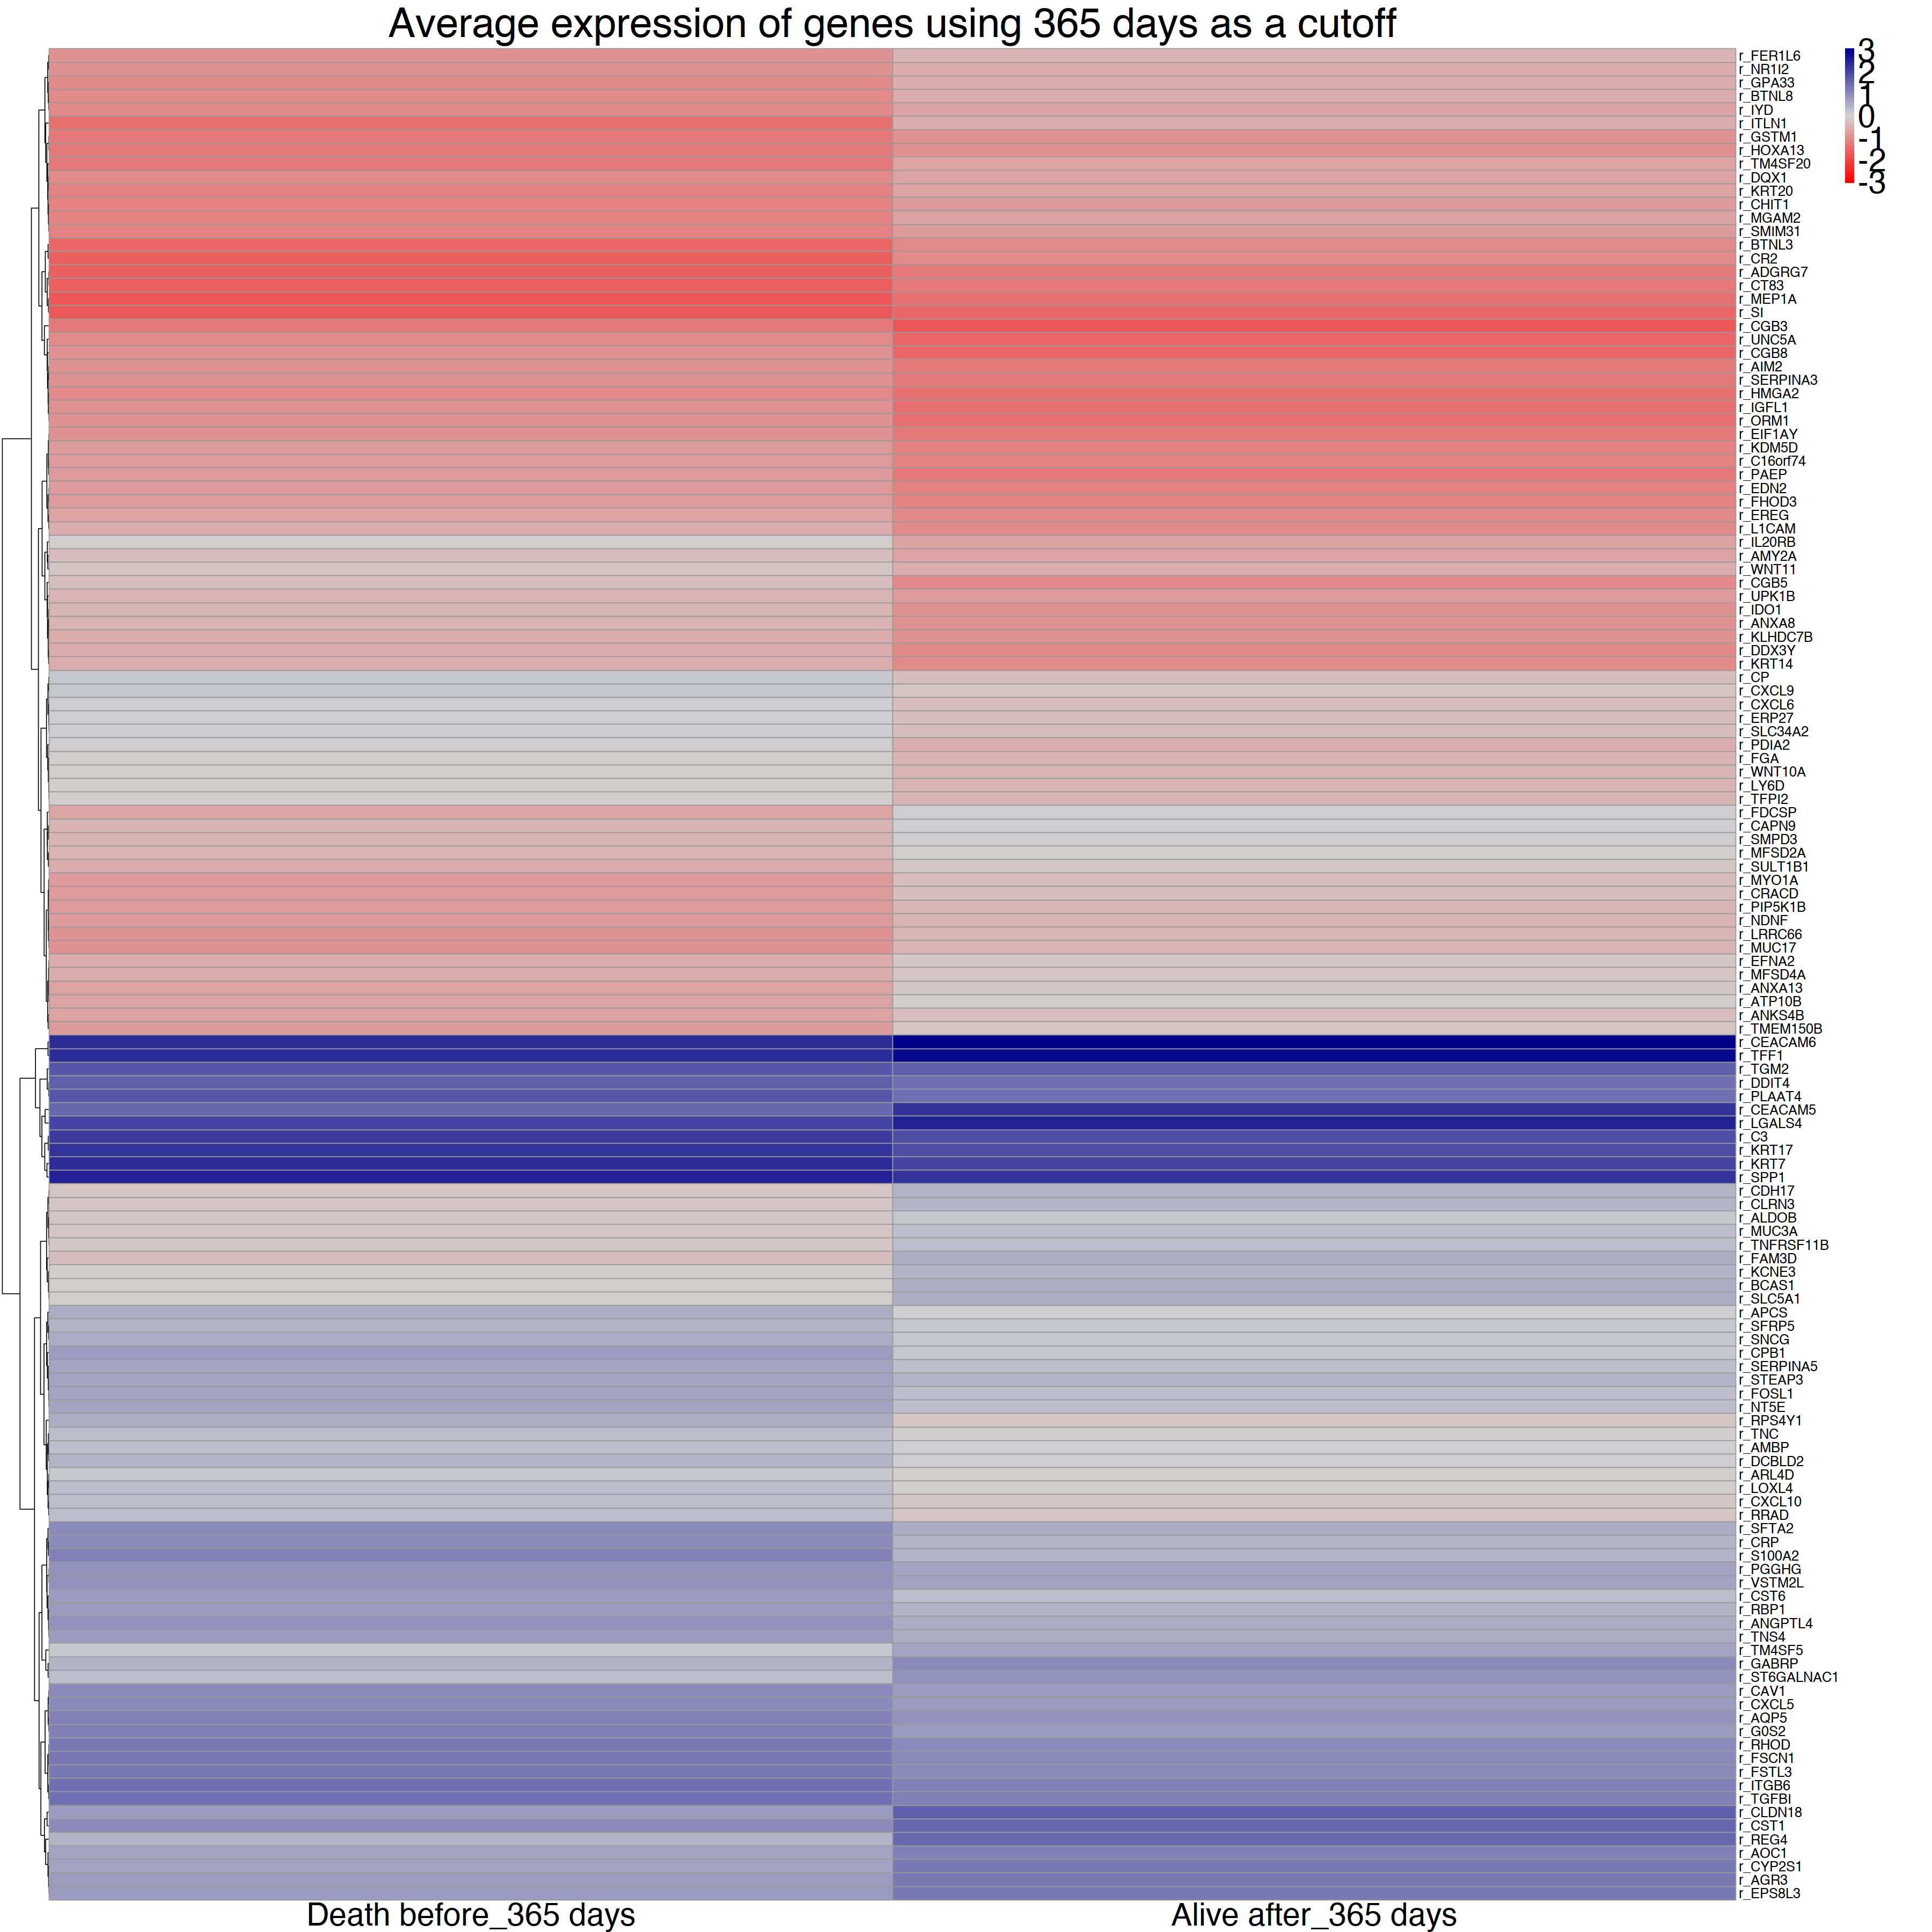

In [21]:
cutoff <- DAYS_IN_YEAR
plot_heatmap(wide_pc, distance_expressed=0.5)